In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd

In [2]:
df = pd.read_csv("backprop.csv")                  
df.head()

,x,y
0,-5.00000,0.006693
1,-4.98999,0.006760
2,-4.97998,0.006827
3,-4.96997,0.006895
4,-4.95996,0.006964


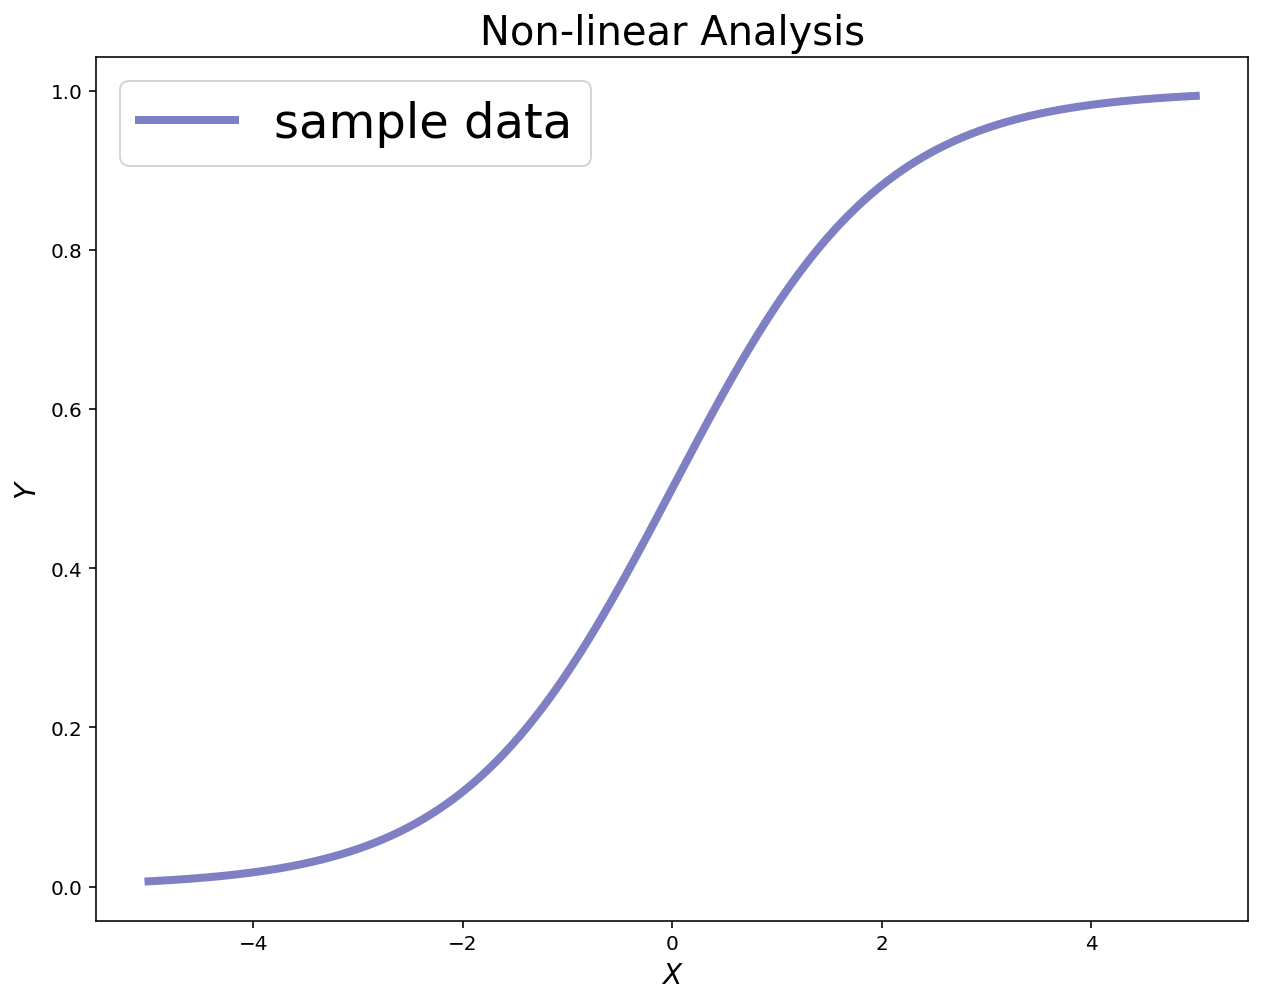

In [12]:
train_size = len(df)
noise = 1.0
X,y = df.x.values.reshape(-1,1), df.y.values.reshape(-1,1)
plt.figure(figsize=(4,6))
plt.plot(X, y,color='darkblue' , lw=4,alpha = 0.5, label='sample data')
plt.title('Non-linear Analysis',fontsize=20); 
plt.xlabel('$X$',fontsize=14); 
plt.ylabel('$Y$',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend(fontsize=24)
plt.savefig('sampledata.png',transparent=True,pad_inches=1)

In [13]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
import tensorflow as tf

def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma
  
def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))
  
# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

In [27]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
  
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches
  
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [28]:
# Build model.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=1,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight)
])

In [29]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

In [31]:
model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=5000, verbose=0);

In [18]:
import tqdm

In [34]:
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)
y_pred_list = []
for i in tqdm.tqdm(range(1000)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    

100%|██████████| 1000/1000 [00:29<00:00, 33.61it/s]


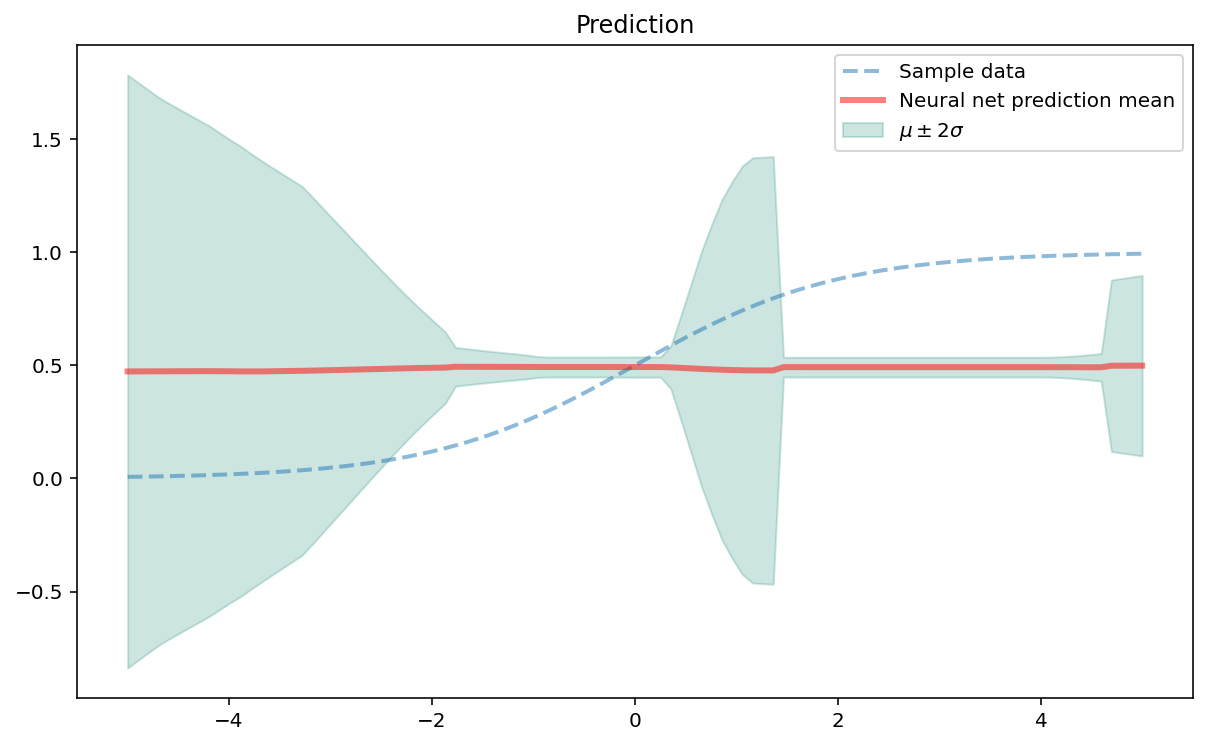

In [35]:
plt.figure(figsize=(10,6))
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X, y,'--', label='Sample data',lw=2,alpha=0.5)
plt.plot(X_test, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(X_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm 2\sigma$')
plt.title('Prediction')
plt.legend();